In [130]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [131]:
# Load the dataset
data = pd.read_csv("IndiaAQI.csv")

# Display the first few rows of the dataset
print(data.head())

  Country           State       City                         Station  \
0   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
1   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
2   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
3   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   
4   India  Andhra_Pradesh  Amaravati  Secretariat, Amaravati - APPCB   

    Latitude  Longitude          Last Update Pollutant  Min  Max  Avg  AQI  \
0  16.515083  80.518167  20-11-2023 12:00:00     PM2.5  NaN  NaN  NaN  NaN   
1  16.515083  80.518167  20-11-2023 12:00:00      PM10  NaN  NaN  NaN  NaN   
2  16.515083  80.518167  20-11-2023 12:00:00       SO2  NaN  NaN  NaN  NaN   
3  16.515083  80.518167  20-11-2023 12:00:00        CO  NaN  NaN  NaN  NaN   
4  16.515083  80.518167  20-11-2023 12:00:00     OZONE  NaN  NaN  NaN  NaN   

  Predominant Parameter  
0                   NaN  
1                   NaN  
2                   

In [132]:
# Clean the dataset
# Convert the 'Last Update' column to datetime
data['Last Update'] = pd.to_datetime(data['Last Update'], format='%d-%m-%Y %H:%M:%S')

# Pivot the data to have pollutants as columns
data_pivot = data.pivot_table(index=['Country', 'State', 'City', 'Station', 'Latitude', 'Longitude', 'Last Update', 'AQI', 'Predominant Parameter'],
                              columns='Pollutant', values='Avg').reset_index()

# Impute missing values with the median value of each column
imputer = SimpleImputer(strategy='median')
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'OZONE', 'CO', 'NH3']
data_pivot[pollutants] = imputer.fit_transform(data_pivot[pollutants])

# Remove rows with missing AQI values
data_pivot = data_pivot.dropna(subset=['AQI'])

# Prepare the features and target variable
features = data_pivot[pollutants]
target = data_pivot['AQI']


In [133]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict AQI on the test set
y_pred = model.predict(X_test)


In [134]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Display the first few predictions
print('First few predictions:', y_pred[:5])

# Save the trained model
joblib.dump(model, 'aqi_predictor_model.pkl')

# Load the model for later use
model = joblib.load('aqi_predictor_model.pkl')

Mean Squared Error: 54.81947362637362
R² Score: 0.9942603663035351
First few predictions: [ 88.21 226.51 204.83 180.53  74.37]


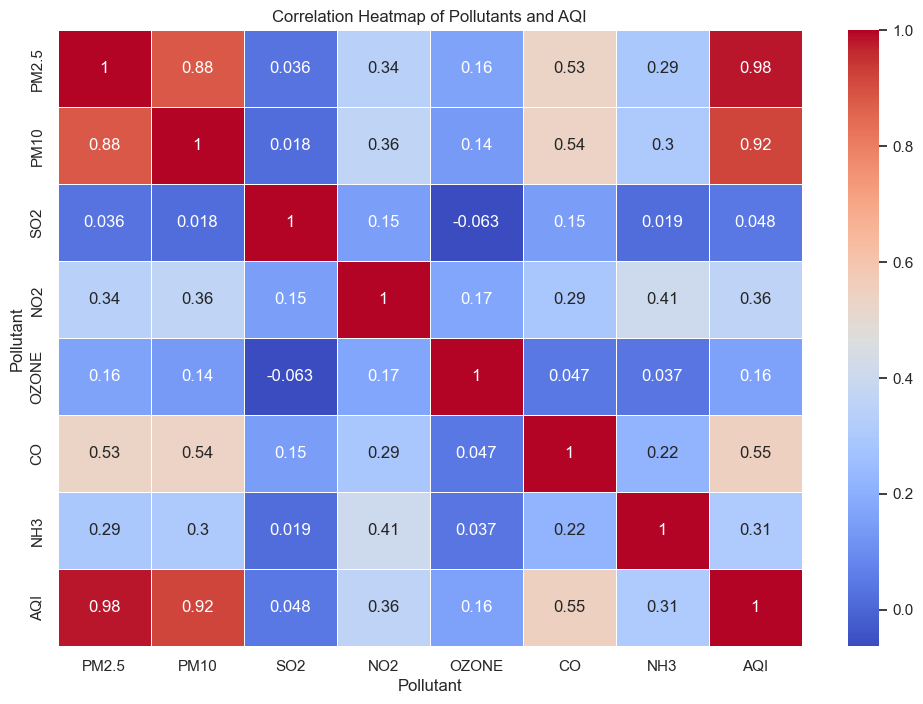

In [135]:

# Calculate the mean of these pollutants and AQI
pollutant_aqi_data = data_pivot[pollutants + ['AQI']].mean()

# Compute the correlation matrix
correlation_matrix = data_pivot[pollutants + ['AQI']].corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Add title and labels
plt.title('Correlation Heatmap of Pollutants and AQI')
plt.show()


Accuracy: 99.43%


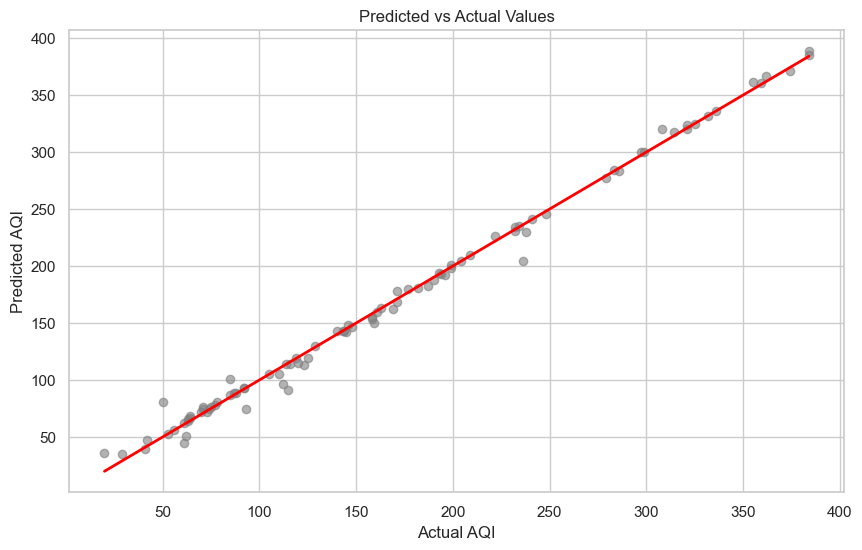

In [136]:
# Calculate and print the R² score as accuracy measure
r2 = r2_score(y_test, y_pred)
accuracy_percentage = r2 * 100
#precision = precision_score(y_test,y_pred)
print(f'Accuracy: {accuracy_percentage:.2f}%')
#print(f'Accuracy: {precision:.2f}%')
#print(f'Accuracy: {recall_score(y_test,y_pred):.2f}%')

# Scatter plot: Predicted vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='grey', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Line for perfect prediction
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.show()

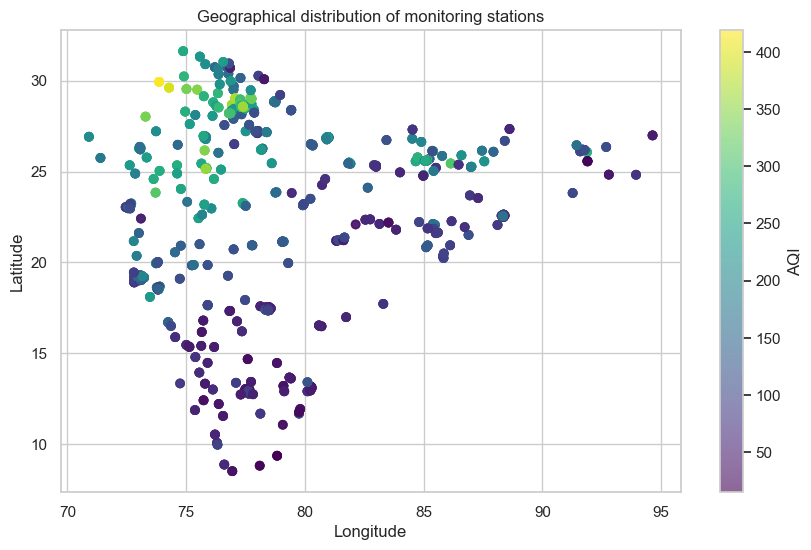

In [137]:
plt.figure(figsize=(10, 6))
plt.scatter(data['Longitude'], data['Latitude'], c=data['AQI'], cmap='viridis', alpha=0.6)
plt.colorbar(label='AQI')
plt.title('Geographical distribution of monitoring stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

C:\Users\Abhishek\AppData\Local\Temp\ipykernel_20476\1584907823.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters


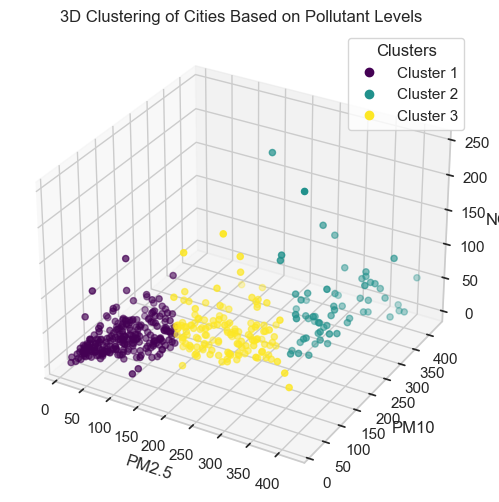

In [138]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features[['PM2.5', 'PM10', 'NO2']])

# Add the cluster information to the dataset
features['Cluster'] = clusters

# Visualize the clusters in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features['PM2.5'], features['PM10'], features['NO2'], c=features['Cluster'], cmap='viridis')

# Add titles and labels
ax.set_title('3D Clustering of Cities Based on Pollutant Levels')
ax.set_xlabel('PM2.5')
ax.set_ylabel('PM10')
ax.set_zlabel('NO2')

# Create a legend
handles, _ = scatter.legend_elements()
labels = [f'Cluster {i+1}' for i in range(kmeans.n_clusters)]
plt.legend(handles, labels, title="Clusters", loc="upper right")

plt.show()


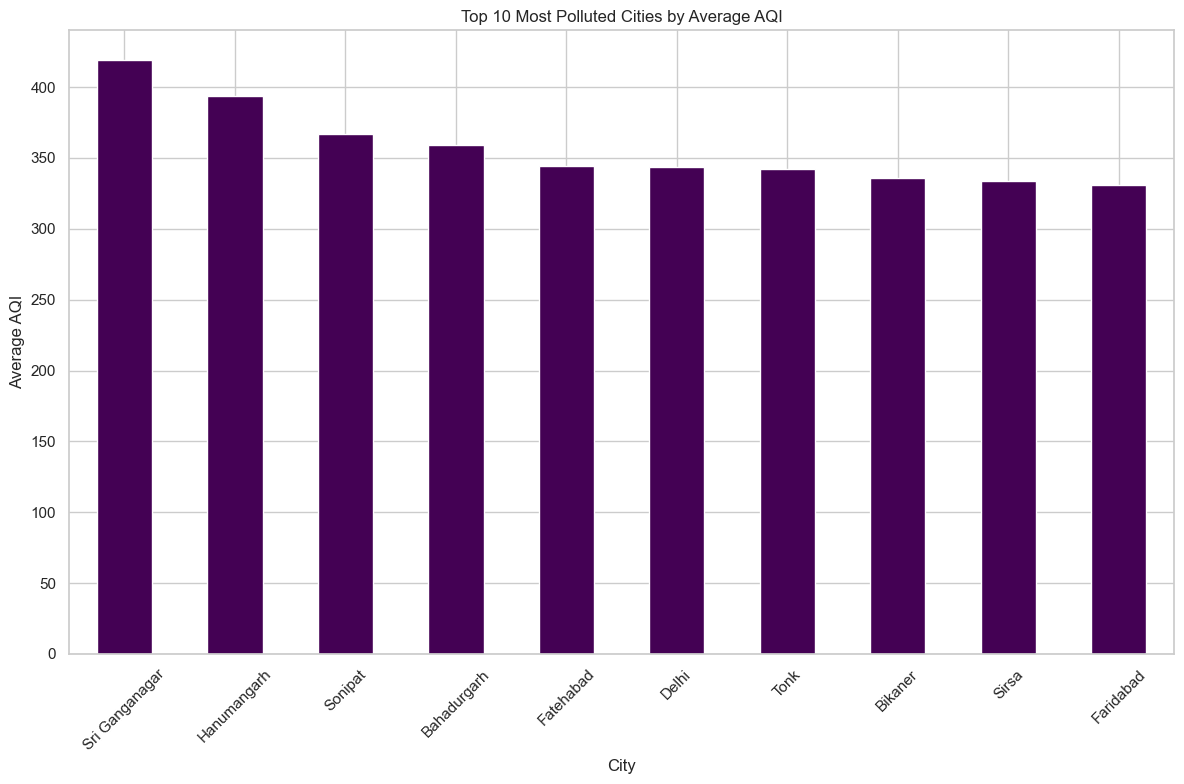

In [139]:
# Calculate the average AQI for each city
city_aqi = data_pivot.groupby('City')['AQI'].mean()

# Get the top 10 most polluted cities based on average AQI
top_polluted_cities = city_aqi.sort_values(ascending=False).head(10)

# Plotting the bar graph
plt.figure(figsize=(12, 8))
top_polluted_cities.plot(kind='bar', cmap='viridis')
plt.title('Top 10 Most Polluted Cities by Average AQI')
plt.xlabel('City')
plt.ylabel('Average AQI')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


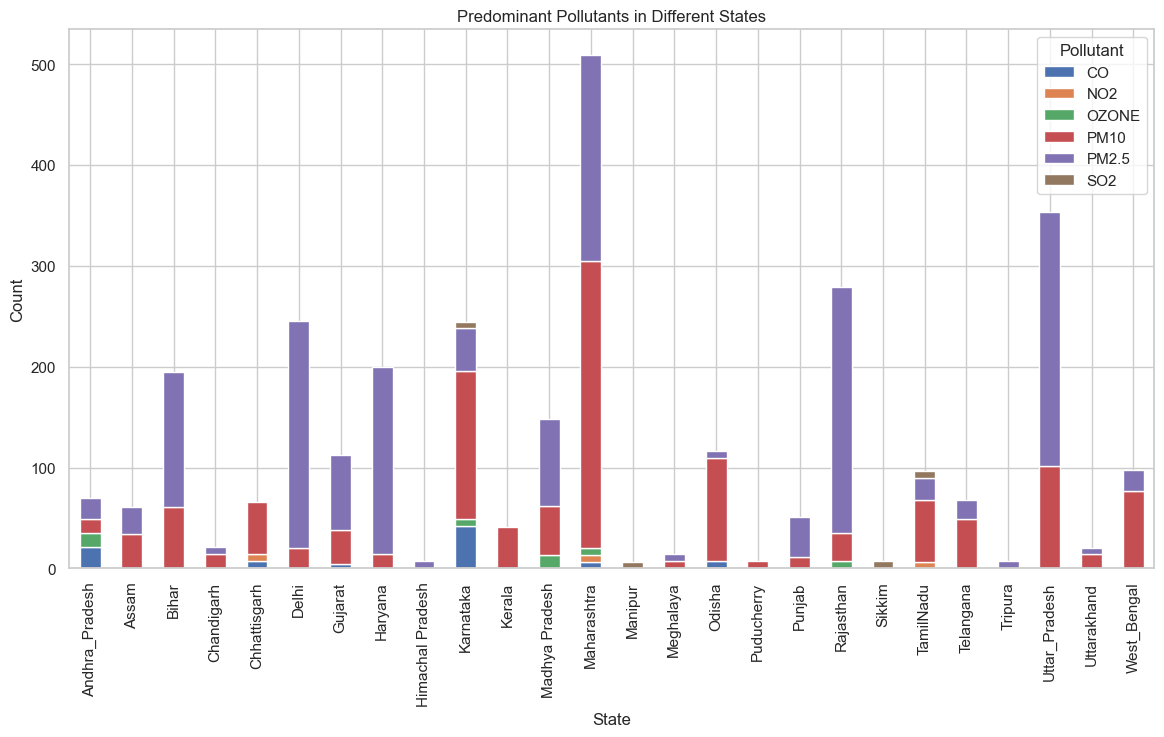

In [141]:
predominant_pollutants = data.groupby(['State', 'Predominant Parameter']).size().unstack().fillna(0)
predominant_pollutants.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Predominant Pollutants in Different States')
plt.xlabel('State')
plt.ylabel('Count')
plt.legend(title='Pollutant')
plt.show()